In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/Bitext_Sample_Customer_Service_Training_Dataset/Training/Bitext_Sample_Customer_Service_Training_Dataset.xlsx
/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/Bitext_Sample_Customer_Service_Training_Dataset/Training/Bitext_Sample_Customer_Service_Training_Dataset.csv
/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/Bitext_Sample_Customer_Service_Training_Dataset/Training/README.txt
/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/Bitext_Sample_Customer_Service_Training_Dataset/Training/LICENSE.txt
/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/README.txt
/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Trainin

In [ ]:
df = pd.read_csv("/kaggle/input/training-dataset-for-chatbotsvirtual-assistants/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")

In [ ]:
df.head()

In [ ]:
df['intent'].unique()

In [ ]:
class cfg:
    num_classes=22
    epochs=15
    batch_size=10
    lr=1e-5
    max_length=15

In [ ]:
import numpy as np
import json
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import gc
from transformers import BertTokenizer , BertModel
import matplotlib.pyplot as plt
device = torch.device('cuda')
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['intent']]
        print(df.columns)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = cfg.max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]


    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')




In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, cfg.num_classes)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)


        return (linear_output)

In [ ]:
mdf = df.loc[:,['utterance','intent']]
mdf.columns = ['text','intent']

In [ ]:
mdf.head()

In [ ]:
df_train, df_val = np.split(mdf.sample(frac=1, random_state=42), [int(.9*len(mdf))])

print(len(df_train), len(df_val))

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=cfg.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=cfg.batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=cfg.lr)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = list(train_label).to(device)
                mask = list(train_input['attention_mask']).to(device)
                input_id = list(train_input['input_ids']).squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                
                train_label=train_label.to(device)
                output=output.to(device)
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
class cfg:
    num_classes=22
    epochs=15
    batch_size=10
    lr=1e-5
    max_length=15

In [ ]:
gc.collect()

In [ ]:
s=set(list(mdf['intent']))
j=0
labels={}
for i in s:
    labels[i]=j
    j+=1

In [ ]:
labels

In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [ ]:
EPOCHS = cfg.epochs
model = BertClassifier()
LR = cfg.lr
              
train(model, df_train, df_val, LR, EPOCHS)

In [ ]:
df_train

In [ ]:
!pip install shap

In [2]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df2 = df.loc[:,['utterance','intent']].copy()
df2.columns = ['text','intent']
df2.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2['text'], df2['intent'], test_size=0.2, random_state=7, stratify=df2['intent'])

vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

print(len(y_train), len([t for t in y_train if t])) # 20000 10000
print(len(y_test), len([t for t in y_test if t])) # 5000 2500

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

In [ ]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape) # (5000, 16438, 2)

https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-shap-values-2a0e34219177

In [ ]:
X_test.index[6]

In [ ]:
shap.initjs()

og_idx = 6
ind = X_test.index[og_idx]
print(X_test[ind])
print(y_test[ind])
# This amazing documentary gives us a glimpse into the lives of the brave
# women in Cameroun's judicial system-- policewomen, lawyers and judges. Despite
# tremendous difficulties-- lack of means, the desperate poverty of the people, multiple
# languages and multiple legal precedents depending on the region of the country and
# the religious/ethnic background of the plaintiffs and defendants-- these brave,
# strong women are making a difference. [...]

shap.plots.waterfall(shap_values[og_idx,:,1])

In [ ]:
shap.initjs()

og_idx = 150
ind = X_test.index[og_idx]
print(X_test[ind])
print(y_test[ind])
# This could well be the worst film I've ever seen. Despite what Mikshelt claims,
# this movie isn't even close to being historically accurate. It starts badly and
# then it's all downhill from there. We have Hitler's father cursing his own bad
# luck on the "fact" that he'd married his niece! They were in fact, second cousins.
# Hitler's mother, Klara, called his father, Alois, "uncle" because Alois had been
# adopted and raised by Klara's grandfather and brought up as his son, [...]

shap.plots.waterfall(shap_values[og_idx,:,1])

In [ ]:
shap.initjs()

og_idx = 175
ind = X_test.index[og_idx]
print(X_test[ind])
print(y_test[ind])
shap.plots.waterfall(shap_values[og_idx,:,1])

In [ ]:
shap_values = pd.DataFrame(shap_values[og_idx,:,1].values,feature_names.tolist()).sort_values(by=0, ascending=False)

In [ ]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("cancellation"),1])

In [ ]:
print(feature_names.tolist())

In [ ]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("payment"),1])

In [ ]:
'''
Try this next

https://coderzcolumn.com/tutorials/artificial-intelligence/shap-values-for-text-classification-tasks
'''

In [3]:
x = """LABEL_0": "Analyst Update",

    "LABEL_1": "Fed | Central Banks",

    "LABEL_2": "Company | Product News",

    "LABEL_3": "Treasuries | Corporate Debt",

    "LABEL_4": "Dividend",

    "LABEL_5": "Earnings",

    "LABEL_6": "Energy | Oil",

    "LABEL_7": "Financials",

    "LABEL_8": "Currencies",

    "LABEL_9": "General News | Opinion",

    "LABEL_10": "Gold | Metals | Materials",

    "LABEL_11": "IPO",

    "LABEL_12": "Legal | Regulation",

    "LABEL_13": "M&A | Investments",

    "LABEL_14": "Macro",

    "LABEL_15": "Markets",

    "LABEL_16": "Politics",

    "LABEL_17": "Personnel Change",

    "LABEL_18": "Stock Commentary",

    "LABEL_19": "Stock Movement"
"""

In [4]:
e = {}
for f in [{d.split(':')[0].strip() : d.split(':')[1].strip() } for d in [q.strip().replace('"',"").replace(',','').replace('LABEL_','') for q in x.split('\n') if len(q)>2]]:
    e[list(f.keys())[0]] = list(f.values())[0]
    
print(e)

{'0': 'Analyst Update', '1': 'Fed | Central Banks', '2': 'Company | Product News', '3': 'Treasuries | Corporate Debt', '4': 'Dividend', '5': 'Earnings', '6': 'Energy | Oil', '7': 'Financials', '8': 'Currencies', '9': 'General News | Opinion', '10': 'Gold | Metals | Materials', '11': 'IPO', '12': 'Legal | Regulation', '13': 'M&A | Investments', '14': 'Macro', '15': 'Markets', '16': 'Politics', '17': 'Personnel Change', '18': 'Stock Commentary', '19': 'Stock Movement'}


In [54]:
', '.join(list(e.values())).replace('|','and')

'Analyst Update, Fed and Central Banks, Company and Product News, Treasuries and Corporate Debt, Dividend, Earnings, Energy and Oil, Financials, Currencies, General News and Opinion, Gold and Metals and Materials, IPO, Legal and Regulation, M&A and Investments, Macro, Markets, Politics, Personnel Change, Stock Commentary, Stock Movement'

In [5]:
financial_news_train = pd.read_csv("/kaggle/input/twitter-financial-news/train_data.csv")
financial_news_train.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


In [6]:
financial_news_test = pd.read_csv('/kaggle/input/twitter-financial-news/valid_data.csv')
financial_news_test.head()

,text,label
0,Analyst call of the day for @CNBCPro subscribe...,0
1,"Loop upgrades CSX to buy, says it's a good pla...",0
2,BofA believes we're already in a recession — a...,0
3,JPMorgan sees these derivative plays as best w...,0
4,Morgan Stanley's Huberty sees Apple earnings m...,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(financial_news_train['text'], financial_news_train['label'], test_size=0.8, random_state=7, stratify=financial_news_train['label'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=7, stratify=y_train)

In [9]:
financial_news_train['label'].unique()

array([ 0,  2,  9,  8,  4,  5,  6,  1,  7, 10, 11, 12, 13, 14, 15, 17, 16,
       18, 19,  3])

In [10]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

print(len(y_train), len([t for t in y_train if t])) # 20000 10000
print(len(y_test), len([t for t in y_test if t])) # 5000 2500

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

2378 2342
1020 1005


RandomForestClassifier()

In [11]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape) # (5000, 16438, 2)

100%|===================| 20382/20400 [13:43<00:00]        

(1020, 638, 20)


In [15]:
shap_values[1,:,:]

.values =
array([[ 3.33333330e-06,  5.00000024e-06, -5.60714277e-04, ...,
         5.00000024e-06, -4.99999907e-06,  0.00000000e+00],
       [ 8.33333354e-06, -7.50000018e-05, -5.46428554e-05, ...,
         0.00000000e+00, -7.14285707e-07, -3.00000006e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.31595241e-03, -3.11190480e-04, -5.60492426e-03, ...,
        -1.18658732e-03,  4.33055557e-03,  4.30924602e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000004e-05,  2.16666673e-05,  5.89404772e-04, ...,
         3.33333341e-05, -4.20238078e-05,  5.00000024e-06]])

.base_values =
array([0.02497, 0.0254 , 0.1997 , 0.0179 , 0.0213 , 0.0526 , 0.013  ,
       0.0346 , 0.0103 , 0.1319 , 0.0014 , 0.0006 , 0.0217 , 0.0394 ,
       0.1153 , 0.0133 , 0.0512 , 0.05493, 0.1244 , 0.0461 ])

.data =
array(

In [21]:
shap_values[1,shap_values!=0,1]

.values =
array([[ 8.33333354e-06, -7.50000018e-05, -5.46428554e-05,
         8.33333354e-06,  0.00000000e+00,  0.00000000e+00,
        -5.71428594e-06,  0.00000000e+00, -3.33333330e-06,
         1.16428572e-04,  9.52380942e-07,  0.00000000e+00,
         8.33333354e-06,  3.57142853e-07,  2.16666667e-05,
         0.00000000e+00,  5.00000024e-06,  0.00000000e+00,
        -7.14285707e-07, -3.00000006e-05]])

.base_values =
0.0254

.data =
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.31231984, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.      

2288     Tesla still sees 50% average annual growth in ...
3389     Pfizer will spend almost half a billion dollar...
14044                                      $MAC $THO $CNTQ
2983     TWITTER - AS OF JULY 13, STOCKHOLDER APPROVAL ...
3410     EasyJet shareholders vote in favor of an order...
                               ...                        
8410     Mortgage boycotts in China’s property sector. ...
3511     Siemens has the responsibility for transportin...
8590     Today's market action sponsored by  Watching G...
6157     BOJ:BOARD'S CORE-CORE CPI MEDIAN FORECAST FOR ...
9739     $SBUX - Starbucks set to sell Russian business...
Name: text, Length: 1020, dtype: object

Text:  9 Ideal Inflation Buster Dividend Dogs To Buy In July.  https://t.co/JuxuC6Y4mm #stocks #economy #markets
Label :  Stock Commentary


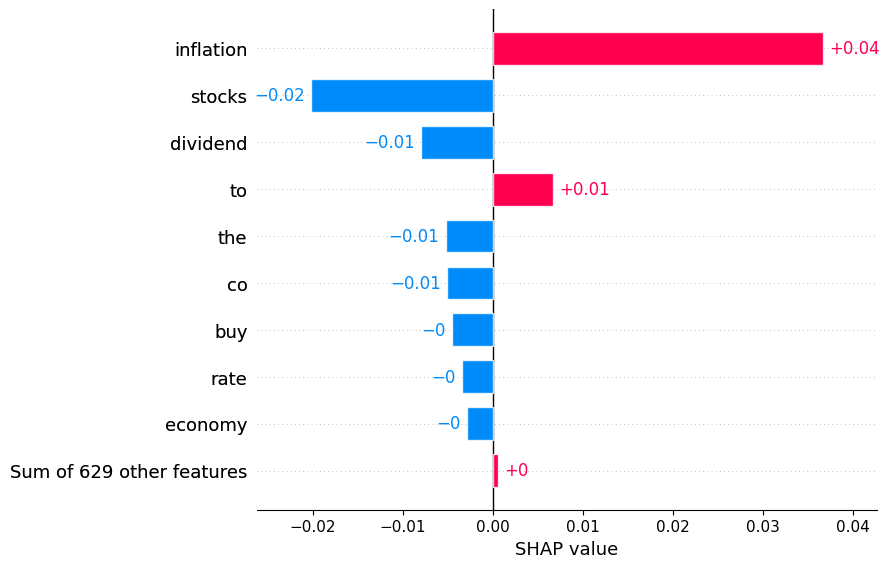

Text:  The flow of commodities to inland Europe is starting to buckle as water levels on the Rhine river continue to fall  https://t.co/hVVYw8926M
Label :  Macro


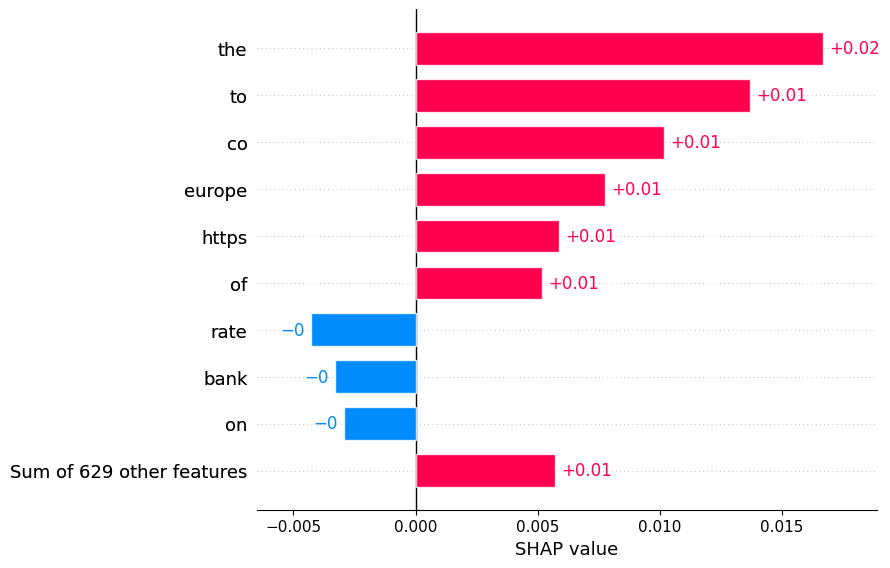

Text:  BRENT CRUDE OIL FUTURES RISE OVER $3 TO $104.36 A BARREL
Label :  Energy | Oil


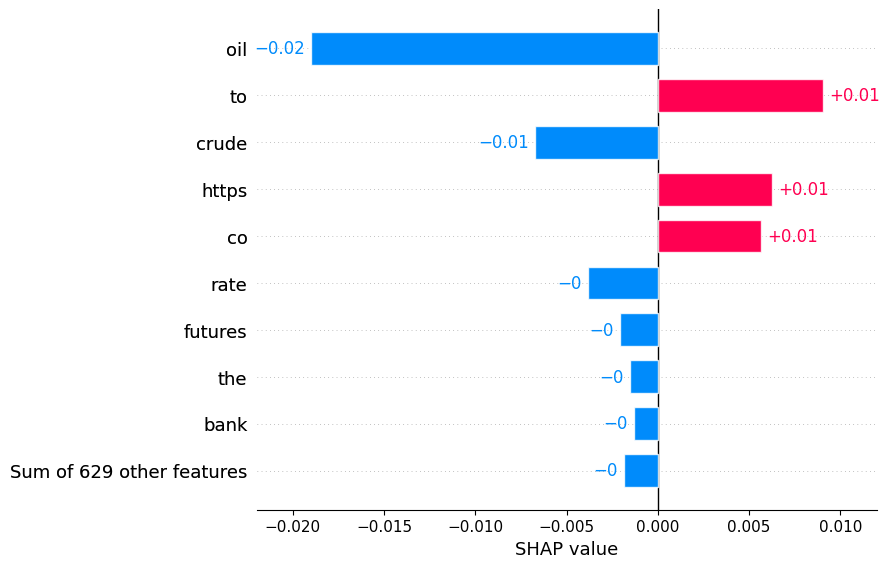

Text:  China risks a hard landing in the real-estate sector and needs to step in to resolve both the liquidity crunch for developers and the recent boycotts of mortgage payments, a former official says  https://t.co/ht7eVbFHmQ
Label :  Macro


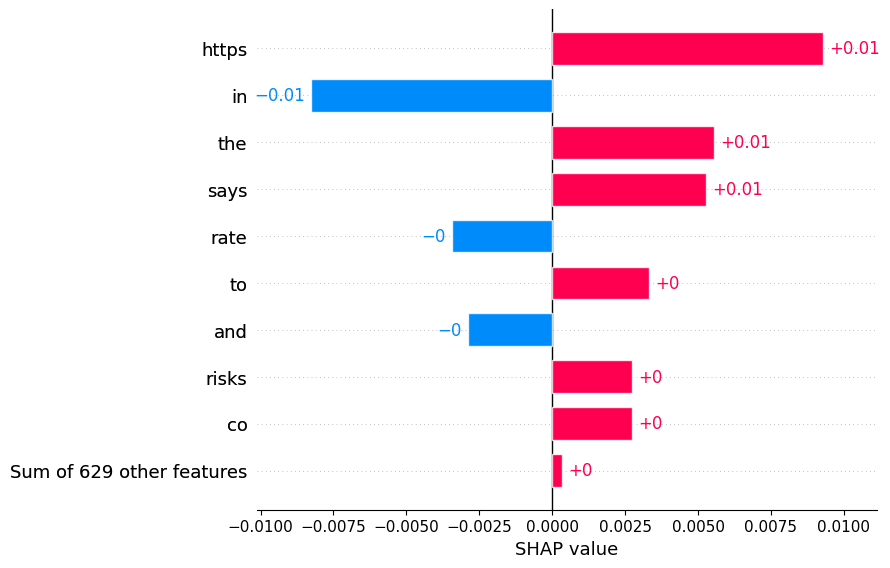

Text:  $LMST - Limestone Bancorp GAAP EPS of $0.53 beats by $0.06, revenue of $13.94M beats by $2.79M  https://t.co/vYpy9ATpr1
Label :  Financials


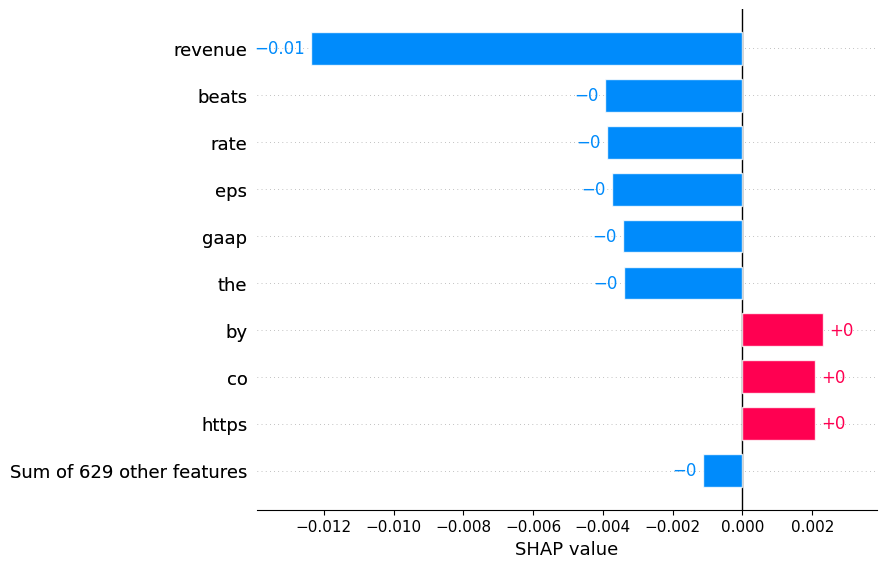

In [44]:
for x in range(0,5):
    print("Text: " ,list(X_test)[80+x])
    print("Label : " ,e[str(list(y_test)[80+x])])
    shap.plots.bar(shap_values[80+x,:,1],max_display=10)

TypeError: 'numpy.float64' object is not iterable

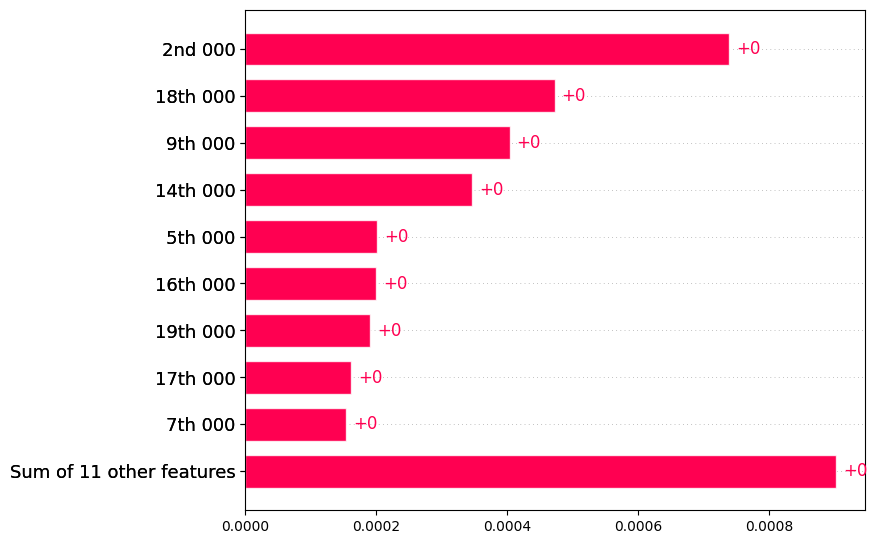

In [64]:
shap.plots.bar(shap_values.abs.mean(0))

In [29]:

# Convert shap_values to numpy array if needed
shap_values_array = np.array([shap_values[i].values for i in range(len(shap_values))])

# Define the threshold
threshold = 0.004

# Select elements where the values in the middle dimension are greater than the threshold
selected_elements = shap_values_array[1, :, 1] > threshold

# Applying the boolean mask to the middle dimension to get the desired elements
filtered_shap_values = shap_values_array[1, selected_elements, :]

# Print the filtered shap values
print(filtered_shap_values)

[[-0.00485066  0.00435246 -0.05736411 -0.0082898  -0.00229651 -0.00122667
   0.0002052  -0.00138978 -0.00012349  0.06806046  0.00084877  0.0031644
   0.00316496 -0.00764723  0.01613634  0.00199155  0.00130738 -0.00598942
  -0.00826862 -0.00178524]]


In [34]:
# Assuming filtered_shap_values still retains the same shape and structure
shap.summary_plot(filtered_shap_values, X_test, feature_names=vectorizer.get_feature_names_out())

IndexError: tuple index out of range

In [65]:
import pickle
import warnings
from pprint import pprint

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split

import shap

In [66]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [70]:
random_state = 42
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test]
)

TypeError: Cannot initialize Dataset from Series

In [71]:
shap.plots.heatmap(shap_values)

DimensionError: The hclust order only supports 2D arrays right now!

In [74]:
shap.plots.scatter(shap_values[:, '0'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices